In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

In [168]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy import stats

In [143]:
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.stattools import adfuller

from sklearn import preprocessing

In [12]:
repair = pd.read_excel('Preston Repairs/Output/preston_repairs.xlsx', index_col = None, sheet_name = 'Data')
repair.head()

,serialnumber,model_num,created_date,received_date,fault_code,repair_code,action_code,work_description,part_number,part_description,number,fault_category,sequence_repair,month,year,repair_date,site,device_utilization,total_devices
0,21240522504139,TC57,2023-01-25,2023-01-27,Damage-Touch Panel Impact,Touch Panel,Replace/Install,NaN,AS-000369-01,ASSEMBLY TOUCH LCD NISSHA WITH FFC HOLE FOR TC...,INC4269170,Damage,1,1,2023,2023-01-25,1166-SLOUGH DO,159,161
1,21226522504129,TC57,2023-01-31,2023-02-01,Touch Panel-Incorrect Reaction,Main Pcb,Replace/Install,bnb,16M.05PMB.0010,QA268 MB WWAN RM SKU SERVICE,INC4277449,Touch Panel,1,1,2023,2023-01-31,1166-SLOUGH DO,159,161
2,21177522503472,TC57,2023-01-25,2023-01-27,Damage-Connector,Connector,Replace/Install,NaN,16H.05PMS.0002,"CONNECTOR, DOCKING",INC4270166,Damage,1,1,2023,2023-01-25,1010-LISKEARD DO,28,28
3,21197522508933,TC57,2023-01-25,2023-01-27,Display-Blank,Connector,"Upgraded (Ff,Dcn)",NaN,NaN,NaN,INC4270477,Display,1,1,2023,2023-01-25,1099-PORT TALBOT DO,43,43
4,21212522503693,TC57,2023-01-25,2023-01-27,Touch Panel-No Reaction,Touch Panel,Replace/Install,NaN,AS-000369-01,ASSEMBLY TOUCH LCD NISSHA WITH FFC HOLE FOR TC...,INC4271101,Touch Panel,1,1,2023,2023-01-25,305-STRATFORD UPON AVON DO,68,69


In [13]:
repair.drop(columns = ['year', 'month'], inplace = True)

In [16]:
repair.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41032 entries, 0 to 41031
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   serialnumber        41032 non-null  int64         
 1   model_num           41032 non-null  object        
 2   created_date        41032 non-null  datetime64[ns]
 3   received_date       41032 non-null  datetime64[ns]
 4   fault_code          41032 non-null  object        
 5   repair_code         41029 non-null  object        
 6   action_code         41032 non-null  object        
 7   work_description    9849 non-null   object        
 8   part_number         37658 non-null  object        
 9   part_description    37658 non-null  object        
 10  number              41032 non-null  object        
 11  fault_category      41032 non-null  object        
 12  sequence_repair     41032 non-null  int64         
 13  repair_date         41032 non-null  datetime64

In [37]:
print(repair['created_date'].min(), repair['created_date'].max())

2023-01-25 00:00:00 2024-11-25 00:00:00


In [43]:
start_date = '2023-01-25'
end_date = '2024-11-25'

dates_dataframe = pd.DataFrame({'calendar_date' : pd.date_range(start_date, end_date)})

In [49]:
dates_dataframe['month'] = dates_dataframe['calendar_date'].dt.month
dates_dataframe['year'] = dates_dataframe['calendar_date'].dt.year
dates_dataframe['week'] = dates_dataframe['calendar_date'].dt.isocalendar().week
# dates_dataframe['calendar_date'] = pd.to_datetime(dates_dataframe['calendar_date']).dt.date
dates_dataframe.head()

,calendar_date,month,year,week
0,2023-01-25,1,2023,4
1,2023-01-26,1,2023,4
2,2023-01-27,1,2023,4
3,2023-01-28,1,2023,4
4,2023-01-29,1,2023,4


In [45]:
dates_dataframe['calendar_date'] = pd.to_datetime(dates_dataframe['calendar_date'])

In [46]:
dates_dataframe.dtypes

calendar_date    datetime64[ns]
month                     int64
year                      int64
week                     UInt32
dtype: object

In [47]:
print(dates_dataframe.shape[0], dates_dataframe['calendar_date'].nunique(), repair['created_date'].nunique())
repair_calendar = dates_dataframe.merge(repair, left_on = ['calendar_date'], right_on = ['created_date'], how = 'left')
print(repair_calendar.shape[0], repair_calendar['calendar_date'].nunique(), repair['created_date'].nunique())

671 671 442
41261 671 442


**35% of the date have zero repairs**

In [ ]:
# train["lags"] = train.groupby(['country', 'store', 'product'])['num_sold'].shift(1)
# train

In [56]:
repair_calendar['week_of_month'] = pd.to_datetime(repair_calendar['calendar_date']).apply(lambda d: (d.day-1) // 7 + 1) 
repair_calendar['day'] = pd.to_datetime(repair_calendar['calendar_date']).dt.dayofweek + 1
repair_calendar['weekday'] = pd.to_datetime(repair_calendar['calendar_date']).dt.day_name()

In [57]:
repair_calendar.head()

,calendar_date,month,year,week,serialnumber,model_num,created_date,received_date,fault_code,repair_code,...,number,fault_category,sequence_repair,repair_date,site,device_utilization,total_devices,week_of_month,day,weekday
0,2023-01-25,1,2023,4,2.124052e+13,TC57,2023-01-25,2023-01-27,Damage-Touch Panel Impact,Touch Panel,...,INC4269170,Damage,1.0,2023-01-25,1166-SLOUGH DO,159.0,161.0,4,3,Wednesday
1,2023-01-25,1,2023,4,2.117752e+13,TC57,2023-01-25,2023-01-27,Damage-Connector,Connector,...,INC4270166,Damage,1.0,2023-01-25,1010-LISKEARD DO,28.0,28.0,4,3,Wednesday
2,2023-01-25,1,2023,4,2.119752e+13,TC57,2023-01-25,2023-01-27,Display-Blank,Connector,...,INC4270477,Display,1.0,2023-01-25,1099-PORT TALBOT DO,43.0,43.0,4,3,Wednesday
3,2023-01-25,1,2023,4,2.121252e+13,TC57,2023-01-25,2023-01-27,Touch Panel-No Reaction,Touch Panel,...,INC4271101,Touch Panel,1.0,2023-01-25,305-STRATFORD UPON AVON DO,68.0,69.0,4,3,Wednesday
4,2023-01-25,1,2023,4,2.120852e+13,TC57,2023-01-25,2023-01-27,Audio-Speaker Failure-No Sound,Defective Speaker,...,INC4267841,Audio,1.0,2023-01-25,25-MOSELEY DO,75.0,76.0,4,3,Wednesday


In [98]:
repair_daily = repair_calendar.groupby(['year', 'month', 'weekday', 'day', 'calendar_date'], as_index = False).agg(
    repair_count = pd.NamedAgg('number', 'nunique')
)

In [64]:
repair_daily[repair_daily['repair_count'] == 0].shape[0]

229

In [107]:
repair_weekly = repair_calendar.groupby(['year', 'week'], as_index = False).agg(
    repair_count = pd.NamedAgg('number', 'nunique')
)

In [108]:
repair_weekly[repair_weekly['repair_count'].isna()]

,year,week,repair_count


In [109]:
repair_weekly["year_week"] = repair_weekly['year'].apply(str) + "-" + repair_weekly['week'].apply(str)
repair_weekly.head()

,year,week,repair_count,year_week
0,2023,4,121,2023-4
1,2023,5,311,2023-5
2,2023,6,215,2023-6
3,2023,7,267,2023-7
4,2023,8,212,2023-8


**Sparsity vanishes from week level onwards**

In [67]:
repair_monthly = repair_calendar.groupby(['year', 'month'], as_index = False).agg(
    repair_count = pd.NamedAgg('number', 'nunique')
)

In [68]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

In [69]:
repair_monthly["year_month"] = repair_monthly['year'].apply(str) + "-" + repair_monthly['month'].apply(str)
repair_monthly.head()

,year,month,repair_count,year_month
0,2023,1,262,2023-1
1,2023,2,1028,2023-2
2,2023,3,1054,2023-3
3,2023,4,968,2023-4
4,2023,5,1285,2023-5


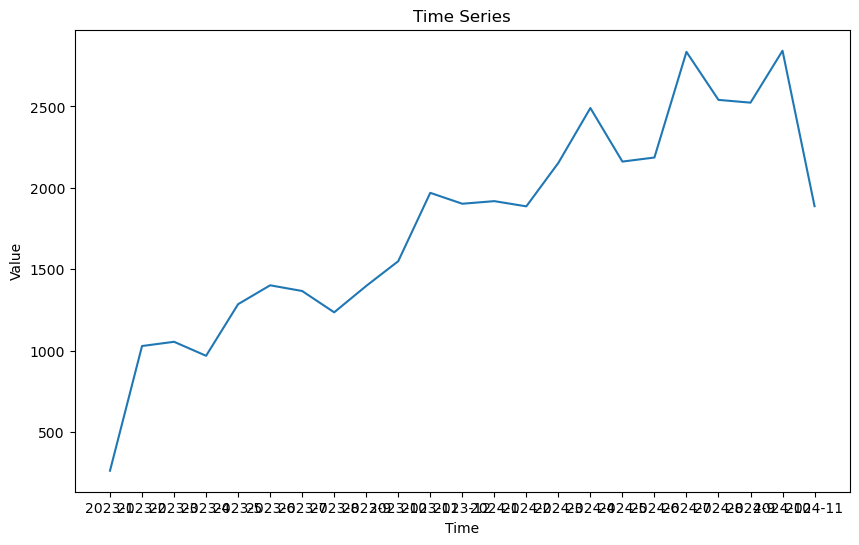

In [70]:
plt.figure(figsize=(10,6))
plt.plot(repair_monthly['year_month'], repair_monthly['repair_count'])
plt.title('Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [82]:
repair_calendar_monthly = repair_calendar.groupby(['year', 'month'], as_index = False).agg(
    repair_count = pd.NamedAgg('number', 'nunique')
)

repair_calendar_weekly = repair_calendar.groupby(['year', 'week'], as_index = False).agg(
    repair_count = pd.NamedAgg('number', 'nunique')
)

repair_calendar_dow = repair_calendar.groupby(['month', 'weekday', 'day'], as_index = False).agg(
    repair_count = pd.NamedAgg('number', 'nunique')
)

# repair_calendar_dow_all = repair_calendar.groupby(['year_month', 'weekday', 'day'], as_index = False).agg(
#     repair_count = pd.NamedAgg('number', 'nunique')
# )

repair_calendar_dow_yr = repair_calendar.groupby(['year', 'weekday', 'day'], as_index = False).agg(
    repair_count = pd.NamedAgg('number', 'nunique')
)

repair_calendar_wom_yr = repair_calendar.groupby(['year', 'week_of_month'], as_index = False).agg(
    repair_count = pd.NamedAgg('number', 'nunique')
)

<AxesSubplot:title={'center':'Seasonal Plot (year/month)'}, xlabel='month', ylabel='repair_count'>

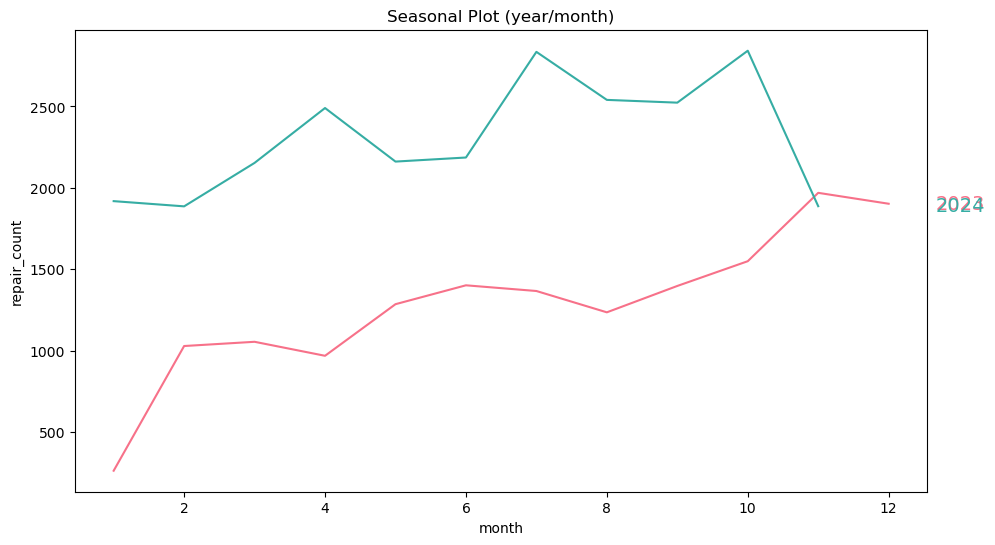

In [71]:
fig, (ax0) = plt.subplots(1, 1, figsize=(11, 6))
seasonal_plot(repair_monthly, y="repair_count", period="year", freq="month", ax=ax0)

**Monthly Sesonality Not Observed**

<AxesSubplot:title={'center':'Seasonal Plot (year/week)'}, xlabel='week', ylabel='repair_count'>

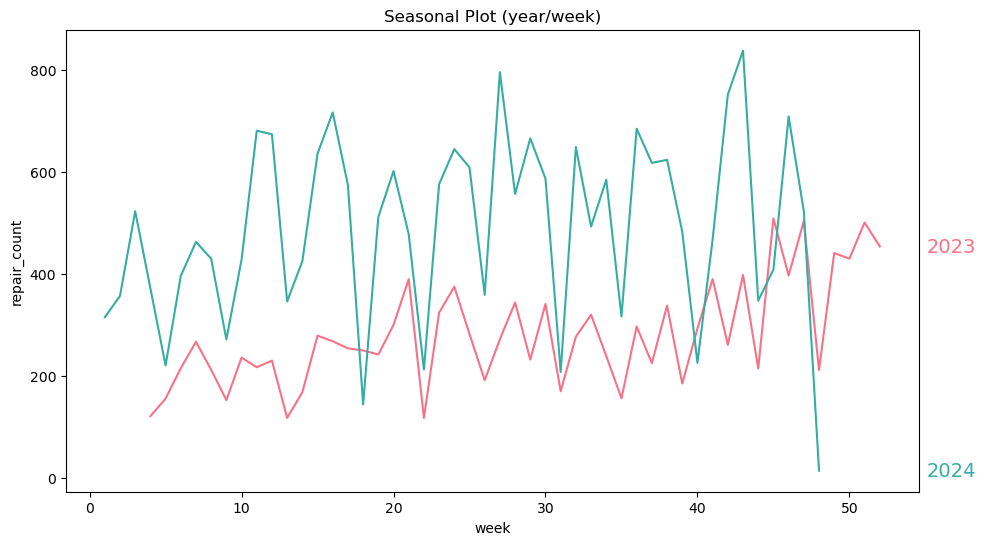

In [72]:
fig, (ax0) = plt.subplots(1, 1, figsize=(11, 6))
seasonal_plot(repair_weekly, y="repair_count", period="year", freq="week", ax=ax0)

**Weak Week of Year Seasonality**

In [81]:
repair_calendar_dow

,month,weekday,day,nunique_sales
0,1,Friday,5,325
1,1,Monday,1,517
2,1,Saturday,6,0
3,1,Sunday,7,1
4,1,Thursday,4,369
...,...,...,...,...
79,12,Saturday,6,0
80,12,Sunday,7,0
81,12,Thursday,4,384
82,12,Tuesday,2,240


<AxesSubplot:title={'center':'Seasonal Plot (year/day)'}, xlabel='day', ylabel='repair_count'>

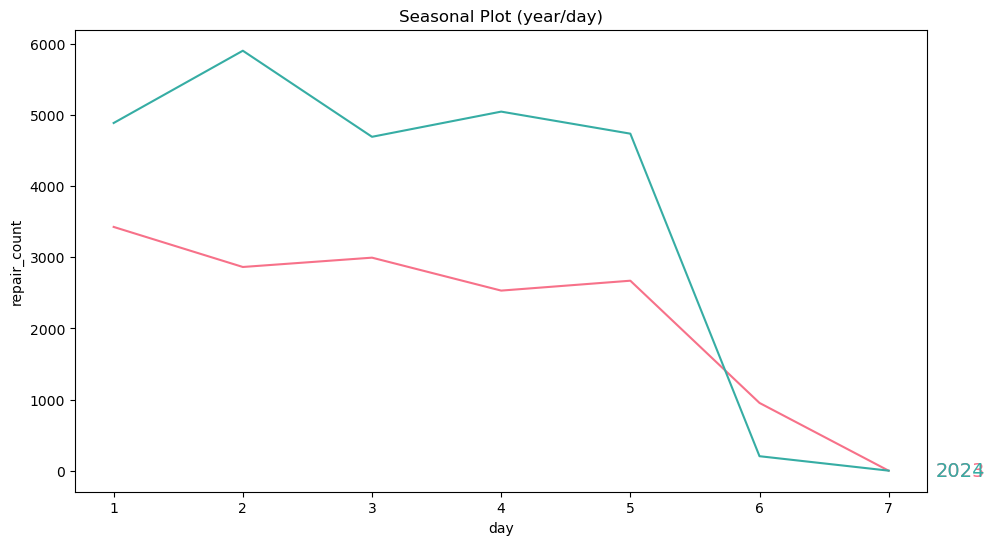

In [84]:
fig, (ax0) = plt.subplots(1, 1, figsize=(11, 6))
seasonal_plot(repair_calendar_dow_yr, y="repair_count", period="year", freq="day", ax=ax0)

<AxesSubplot:title={'center':'Seasonal Plot (year/day)'}, xlabel='day', ylabel='repair_count'>

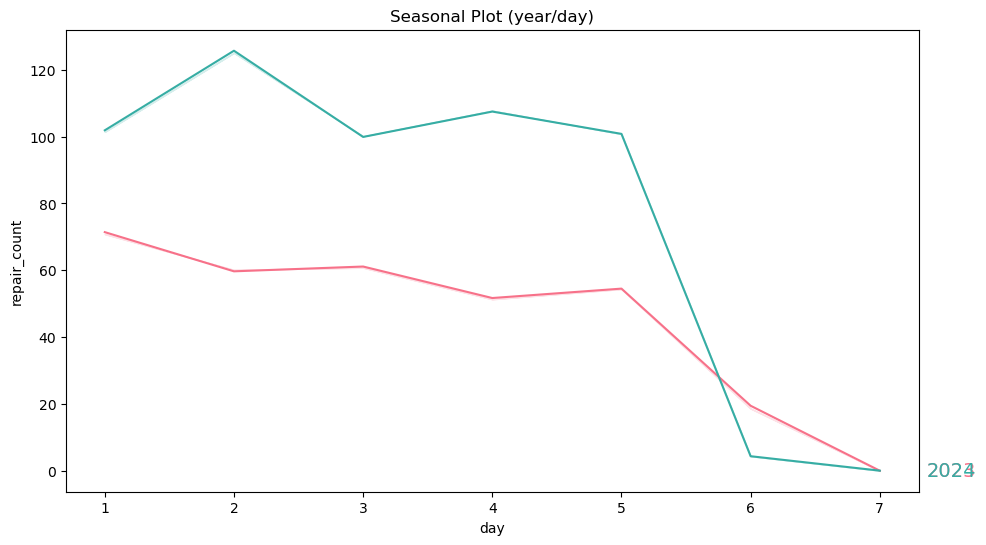

In [100]:
fig, (ax0) = plt.subplots(1, 1, figsize=(11, 6))
seasonal_plot(repair_daily, y="repair_count", period="year", freq="day", ax=ax0)

**Last 3 days of week show seasonality** Which is obvious, Saturaday and Sundays being Weekends

<AxesSubplot:title={'center':'Seasonal Plot (month/day)'}, xlabel='day', ylabel='repair_count'>

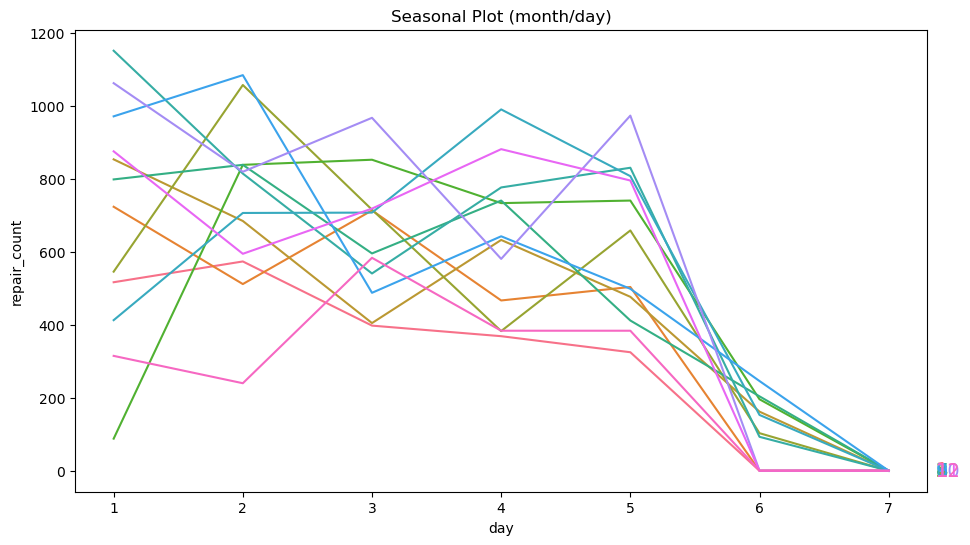

In [91]:
fig, (ax0) = plt.subplots(1, 1, figsize=(11, 6))
seasonal_plot(repair_calendar_dow, y="repair_count", period="month", freq="day", ax=ax0)

<AxesSubplot:title={'center':'Seasonal Plot (year/week_of_month)'}, xlabel='week_of_month', ylabel='repair_count'>

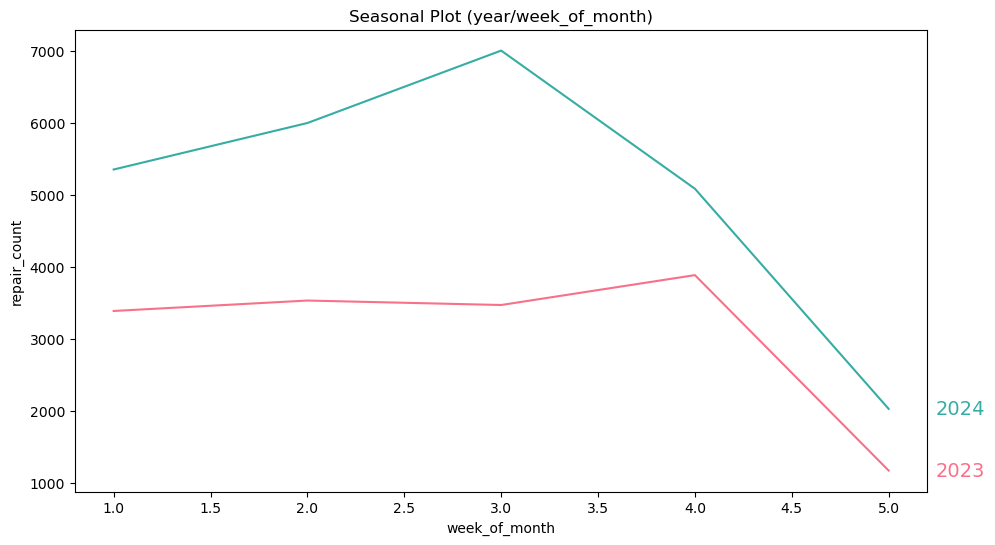

In [101]:
fig, (ax0) = plt.subplots(1, 1, figsize=(11, 6))
seasonal_plot(repair_calendar_wom_yr, y="repair_count", period="year", freq="week_of_month", ax=ax0)

**last week of month is a dip** Which is obvious since it has fewer days

**No Appreciable Seasonality and Seasonal lags would capture any that is there**

# Lets try fourier Terms

In [88]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

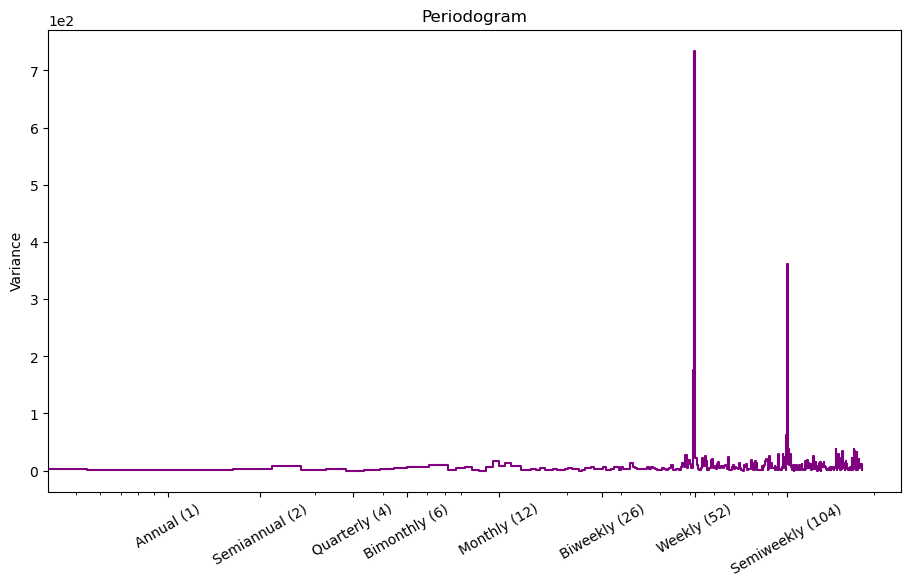

In [89]:
fig, (ax0) = plt.subplots(1, 1, figsize=(11, 6))
plot_periodogram(repair_daily.repair_count, ax = ax0);

**Provides no info whatsover. Look for a kaggle kernel that has used periodgrams successfully to understand how to use it**

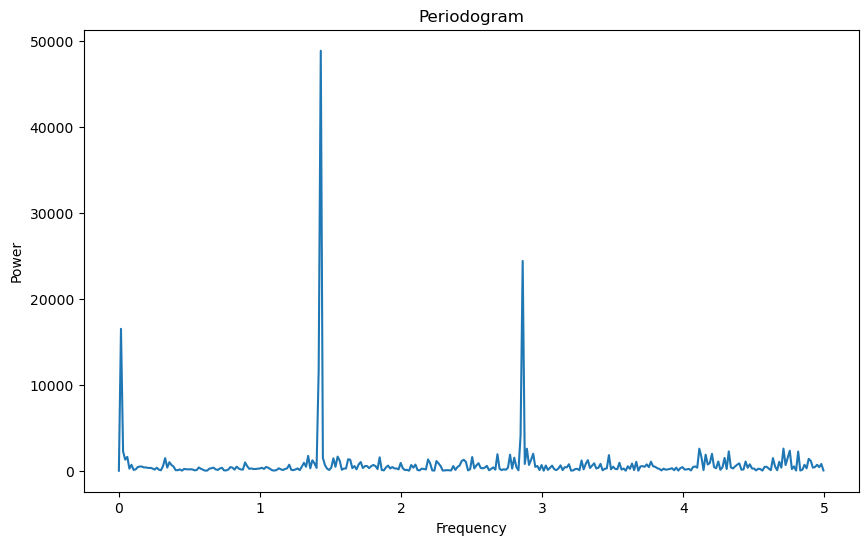

In [94]:
from scipy.signal import periodogram
# Compute the periodogram
freq, power = periodogram(repair_daily.repair_count, fs=10)

# Plot the periodogram
plt.figure(figsize=(10, 6))
plt.plot(freq, power)
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.title('Periodogram')
plt.show()

**Seasonality is done. Now we can move to Trend**

# Trend 

**For the above series linear trend will not work but other methods might.**<br>
1)Moving average: All that remains is chosing the right window<br>
2)STL<br>
3)Hodrick-Prescott Filter. Id on't know how it works, but I am willing to find out.

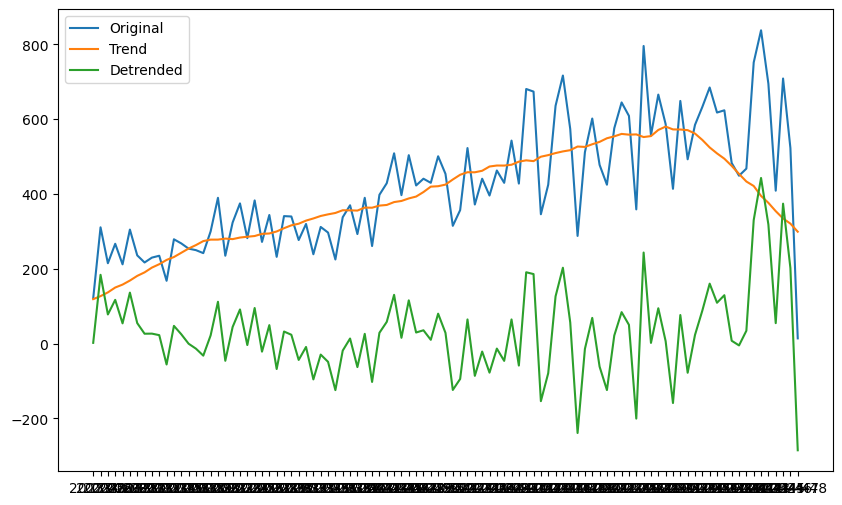

In [110]:
# Moving average detrending
window_size = 30
trend = np.convolve(repair_weekly['repair_count'], np.ones(window_size) / window_size, mode='same')
detrended_x = repair_weekly['repair_count'] - trend

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(repair_weekly['year_week'], repair_weekly['repair_count'], label='Original')
plt.plot(repair_weekly['year_week'], trend, label='Trend')
plt.plot(repair_weekly['year_week'], detrended_x, label='Detrended')
plt.legend()
plt.show()

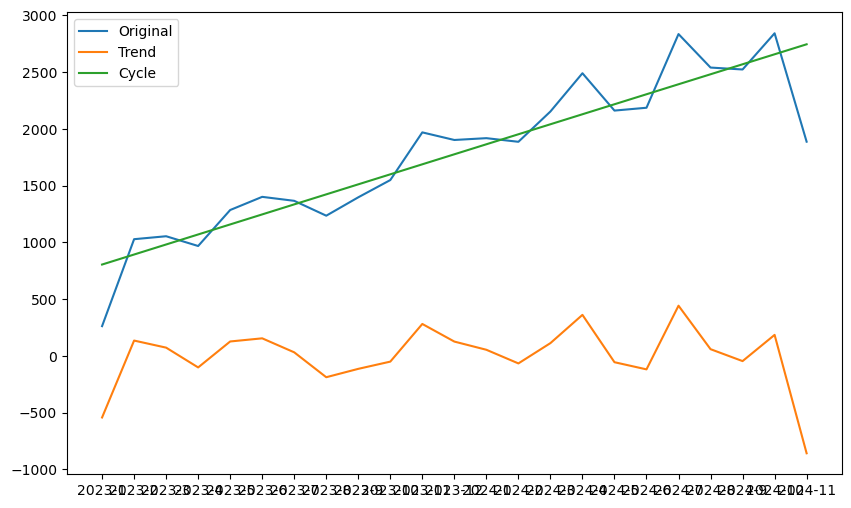

In [112]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.filters.hp_filter import hpfilter

# Hodrick-Prescott filter
trend, cycle = hpfilter(repair_monthly['repair_count'], lamb=160000)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(repair_monthly['year_month'], repair_monthly['repair_count'], label='Original')
plt.plot(repair_monthly['year_month'], trend, label='Trend')
plt.plot(repair_monthly['year_month'], cycle, label='Cycle')
plt.legend()
plt.show()

In [ ]:
# ts_lag_period = ts[ts['year']<2014].copy()
# ts_train = ts[ts['year']>2012].copy()

In [ ]:
# ts_train['seas_lag'] =  pd.to_datetime(ts_train['date'] ) - timedelta(days=365*3)
# ts_train['seas_lag_plus_1'] =  pd.to_datetime(ts_train['date'] ) - timedelta(days=(365 * 3) - 1)
# ts_train['seas_lag_minus_1'] =  pd.to_datetime(ts_train['date'] ) - timedelta(days=(365 * 3) + 1)
# ts_train

In [ ]:
# ts_train.reset_index(inplace = True)

In [ ]:
# ts_train.tail()

In [113]:
print(repair_monthly['year_month'].nunique())

23


In [120]:
np.random.seed(0)
t = np.arange(0, 23, 1)
x = repair_monthly['repair_count']

# Extract the linear trend using linear regression
from sklearn.linear_model import LinearRegression
X = t.reshape(-1, 1)
y = x
model = LinearRegression()
model.fit(X, y)
trend = model.predict(X)

In [135]:
stl = STL(x, seasonal = 3, period = 12)

# Extract the trend, seasonal, and residual components
result = stl.fit()
trend_stl = result.trend

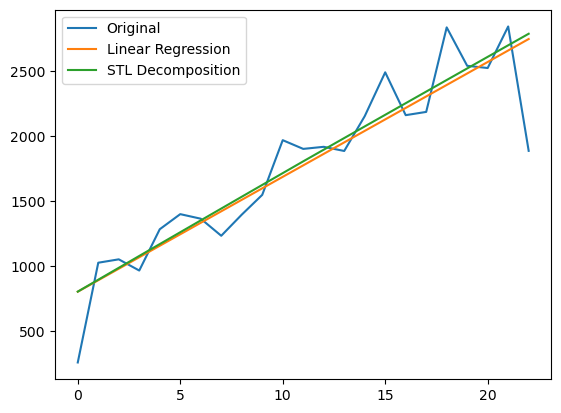

In [136]:
# Plot the original time series and the extracted linear trends
plt.plot(x, label='Original')
plt.plot(trend, label='Linear Regression')
plt.plot(trend_stl, label='STL Decomposition')
# plt.plot(trend_hp, label='HP Filter')
plt.legend()
plt.show()

**Next check about Auto-correlation, stablizing variance, making series stationary, Non Seasonal Arima and Auto Arima**

# ACF Plot

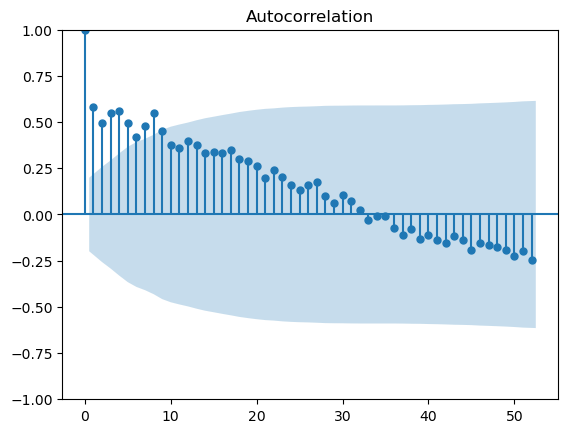

In [141]:
# Create an ACF plot
plot_acf(repair_weekly['repair_count'], lags=52, use_vlines = True)
plt.show()

**PACF**

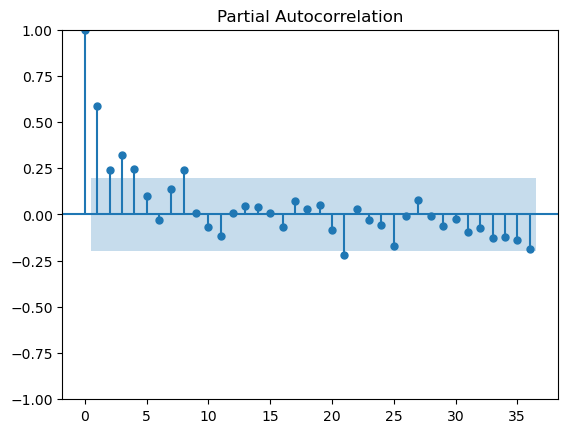

In [149]:
# Create a PACF plot
plot_pacf(repair_weekly['repair_count'], lags=36)
plt.show()

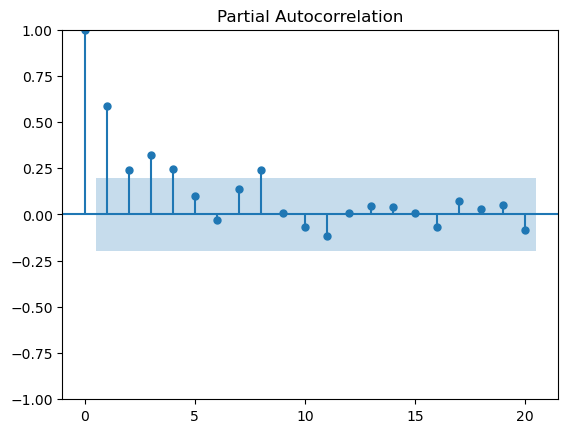

In [146]:
plot_pacf(repair_weekly['repair_count'], lags=20, alpha=0.05, method='yw', ax=plt.gca())
plt.show()

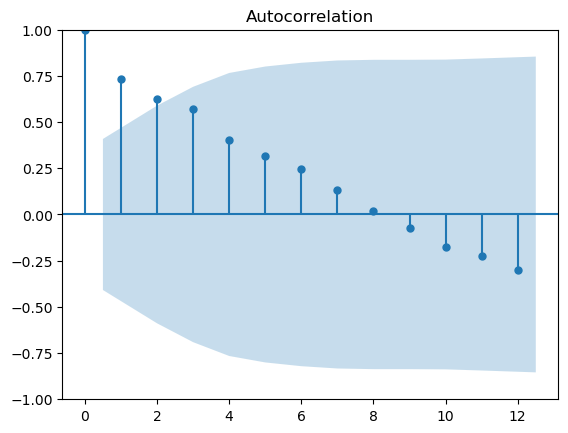

In [151]:
plot_acf(repair_monthly['repair_count'], lags=12, use_vlines = True)
plt.show()

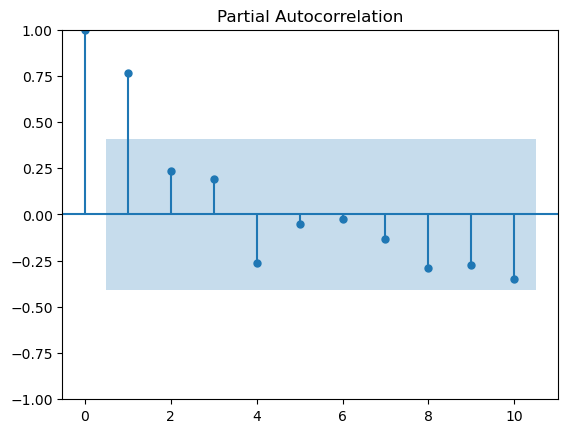

In [153]:
# Create a PACF plot
plot_pacf(repair_monthly['repair_count'], lags=10)
plt.show()

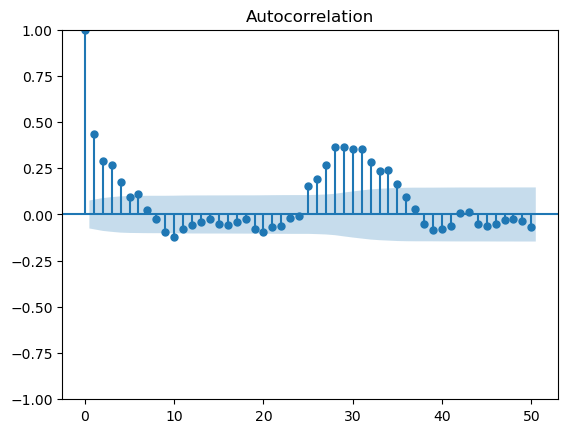

In [156]:
plot_acf(repair_daily['repair_count'], lags=50, use_vlines = True)
plt.show()

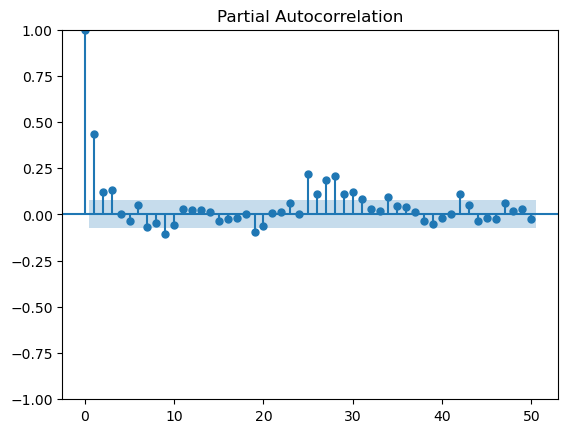

In [158]:
# Create a PACF plot
plot_pacf(repair_daily['repair_count'], lags=50)
plt.show()

# Variance Stablization

In [170]:
repair_daily['log_repair_count'] = np.log(repair_daily['repair_count'])
repair_weekly['log_repair_count'] = np.log(repair_weekly['repair_count'])
repair_monthly['log_repair_count'] = np.log(repair_monthly['repair_count'])

repair_daily['sqrt_repair_count'] = np.sqrt(repair_daily['repair_count'])
repair_weekly['sqrt_repair_count'] = np.sqrt(repair_weekly['repair_count'])
repair_monthly['sqrt_repair_count'] = np.sqrt(repair_monthly['repair_count'])

# repair_daily['bc_repair_count'], bc_lambda_daily = stats.boxcox(repair_daily['repair_count'])
repair_weekly['bc_repair_count'], bc_lambda_weekly = stats.boxcox(repair_weekly['repair_count'])
repair_monthly['bc_repair_count'], bc_lambda_monthly = stats.boxcox(repair_monthly['repair_count'])

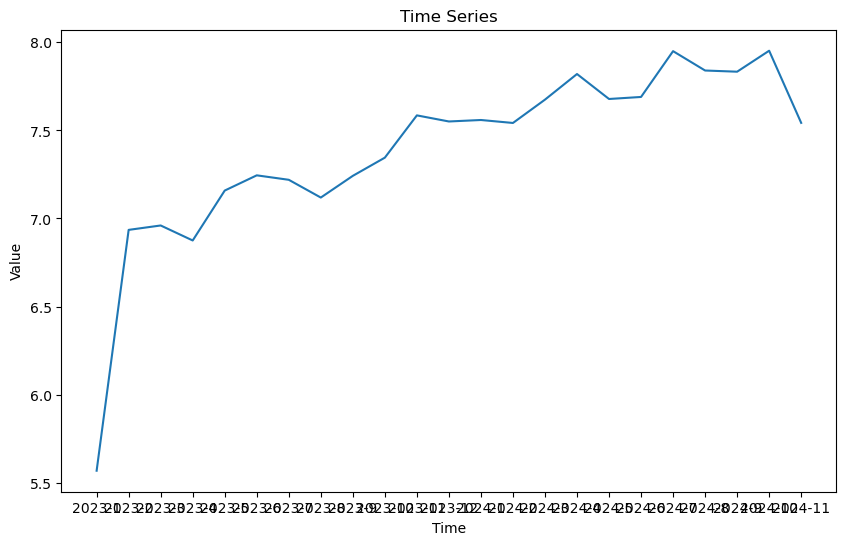

In [163]:
plt.figure(figsize=(10,6))
plt.plot(repair_monthly['year_month'], repair_monthly['log_repair_count'])
plt.title('Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

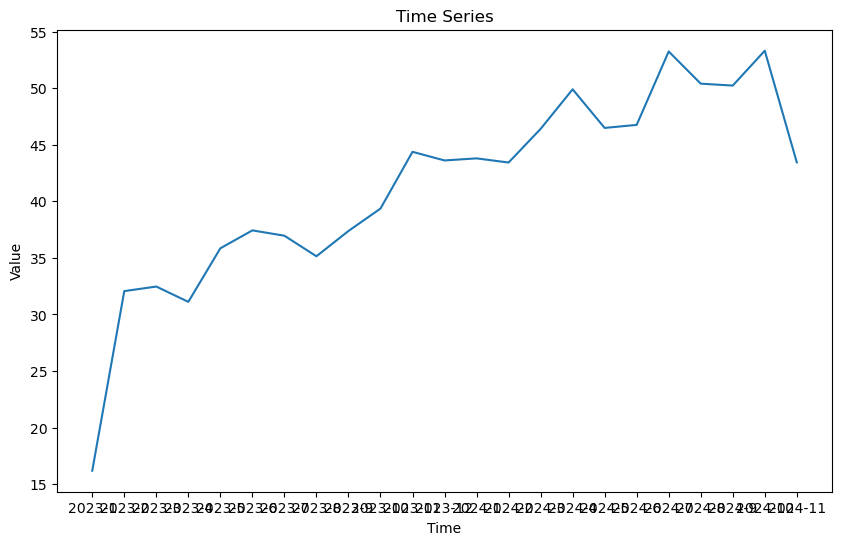

In [166]:
plt.figure(figsize=(10,6))
plt.plot(repair_monthly['year_month'], repair_monthly['sqrt_repair_count'])
plt.title('Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

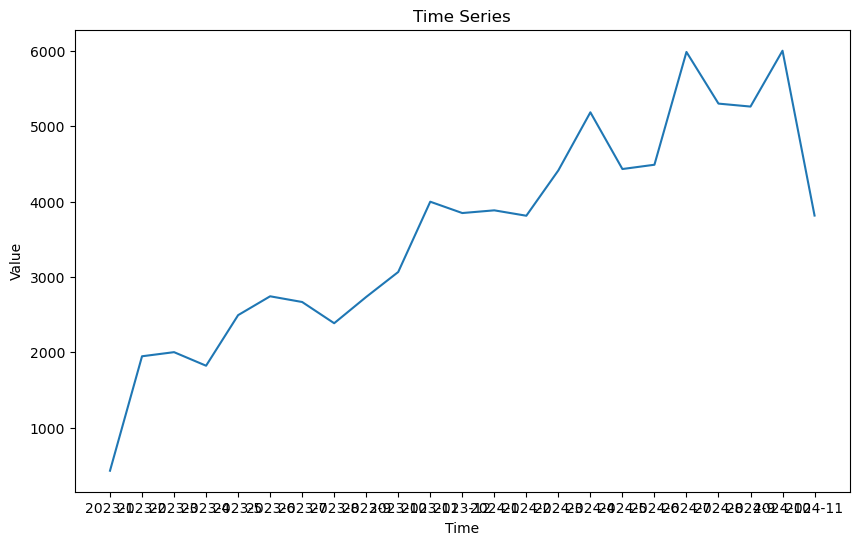

In [171]:
plt.figure(figsize=(10,6))
plt.plot(repair_monthly['year_month'], repair_monthly['bc_repair_count'])
plt.title('Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

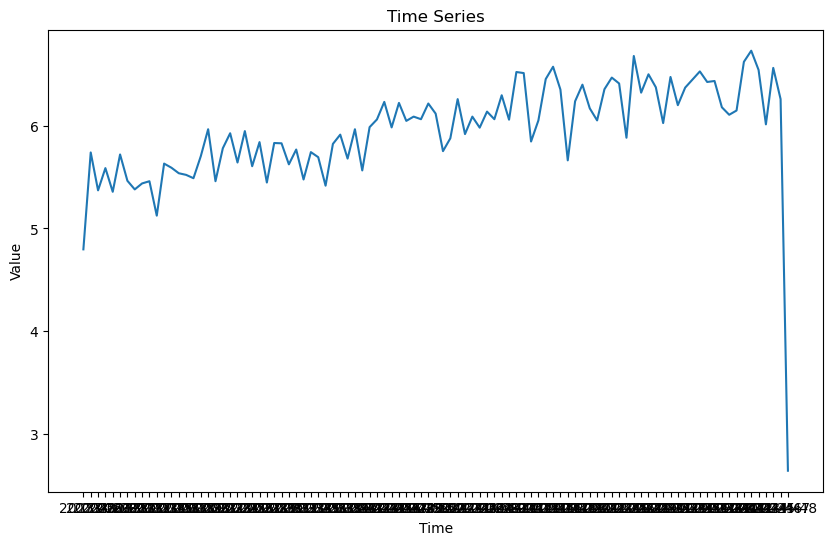

In [164]:
plt.figure(figsize=(10,6))
plt.plot(repair_weekly['year_week'], repair_weekly['log_repair_count'])
plt.title('Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

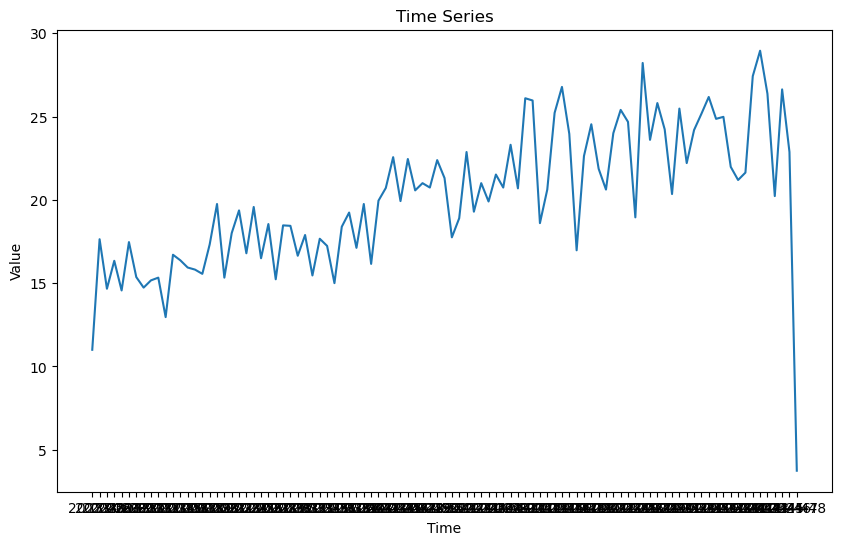

In [167]:
plt.figure(figsize=(10,6))
plt.plot(repair_weekly['year_week'], repair_weekly['sqrt_repair_count'])
plt.title('Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

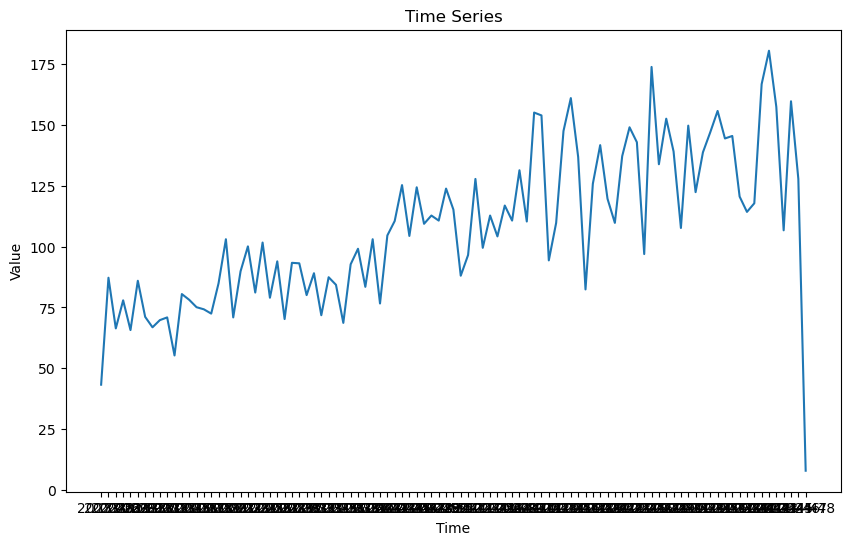

In [172]:
plt.figure(figsize=(10,6))
plt.plot(repair_weekly['year_week'], repair_weekly['bc_repair_count'])
plt.title('Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

**Log transformation is most suited**

#  Making Time Series Stationary

In [181]:
repair_daily['diff_repair_count'] = np.append(np.nan, np.diff(repair_daily['repair_count']))
repair_weekly['diff_repair_count'] = np.append(np.nan, np.diff(repair_weekly['repair_count']))
repair_monthly['diff_repair_count'] = np.append(np.nan, np.diff(repair_monthly['repair_count']))

In [188]:
repair_daily_diff = repair_daily[repair_daily['diff_repair_count'].notna()]
repair_weekly_diff = repair_weekly[repair_weekly['diff_repair_count'].notna()]
repair_monthly_diff = repair_monthly[repair_monthly['diff_repair_count'].notna()]

**Checking for stationarity**

In [186]:
# assume 'x' is the time series
result = adfuller(repair_daily_diff['diff_repair_count'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -11.463118036759212
p-value: 5.492874593942973e-21


In [189]:
# assume 'x' is the time series
result = adfuller(repair_weekly_diff['diff_repair_count'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -5.982783671495865
p-value: 1.8217498036227346e-07


In [190]:
result = adfuller(repair_monthly_diff['diff_repair_count'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -2.3511392175183228
p-value: 0.15600430615791439


In [199]:
repair_monthly['2diff_repair_count'] = np.append([np.nan, np.nan], np.diff(repair_monthly['repair_count'], n=2))
repair_monthly_2diff = repair_monthly[repair_monthly['2diff_repair_count'].notna()]

In [200]:
result = adfuller(repair_monthly_2diff['2diff_repair_count'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -2.869736922534581
p-value: 0.04898205886776616


**For Daily and Weekly level 1 differencing makes the series stationary but level 2 is needed for monthly data**

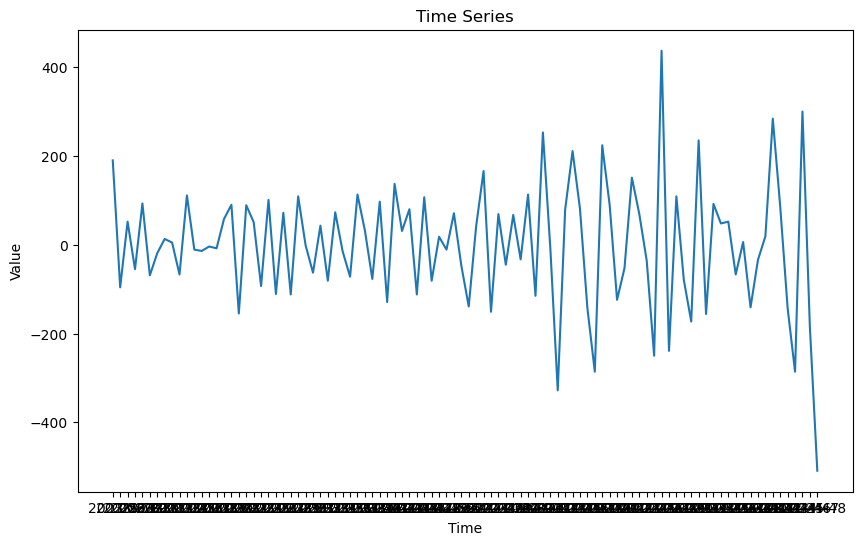

In [226]:
plt.figure(figsize=(10,6))
plt.plot(repair_weekly_diff['year_week'], repair_weekly_diff['diff_repair_count'])
plt.title('Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

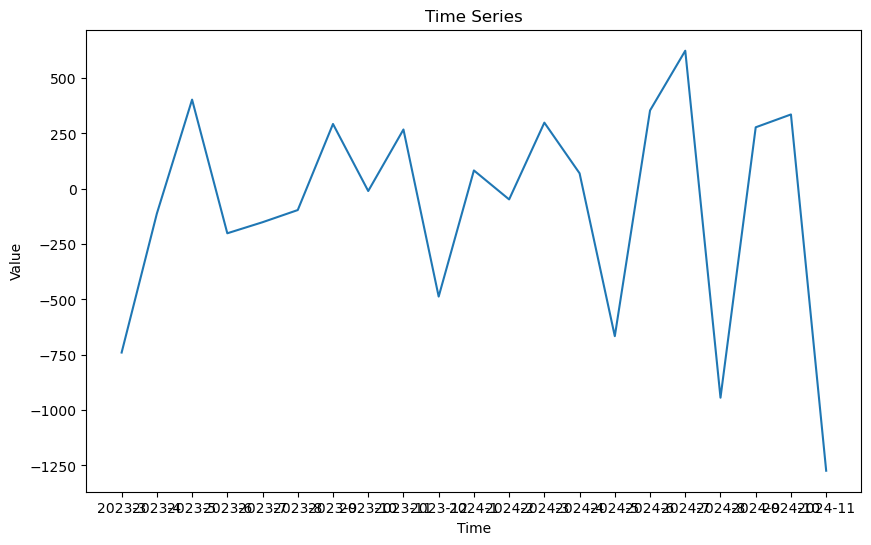

In [228]:
plt.figure(figsize=(10,6))
plt.plot(repair_monthly_2diff['year_month'], repair_monthly_2diff['2diff_repair_count'])
plt.title('Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

**Checking for White Noise**

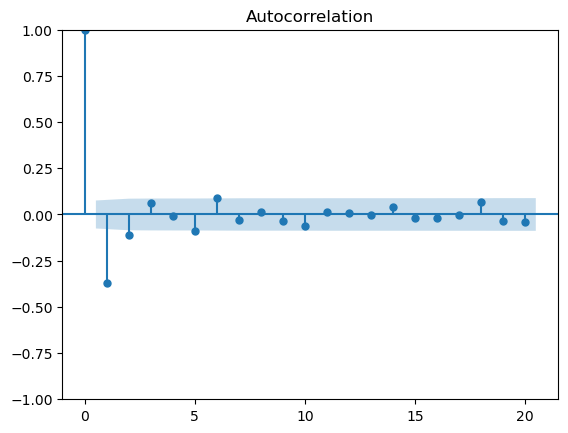

In [220]:
plot_acf(repair_daily_diff['diff_repair_count'], lags=20)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


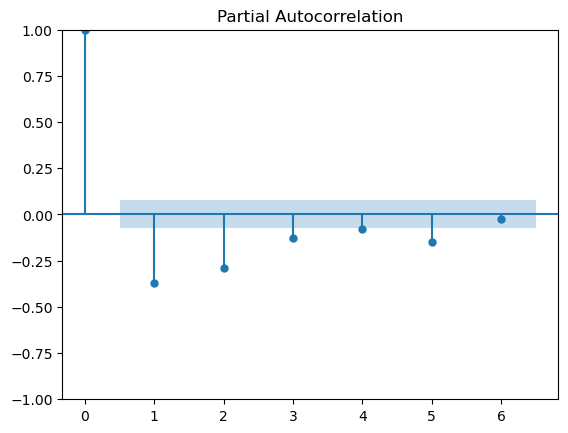

In [221]:
plot_pacf(repair_daily_diff['diff_repair_count'], lags=6)
plt.show()

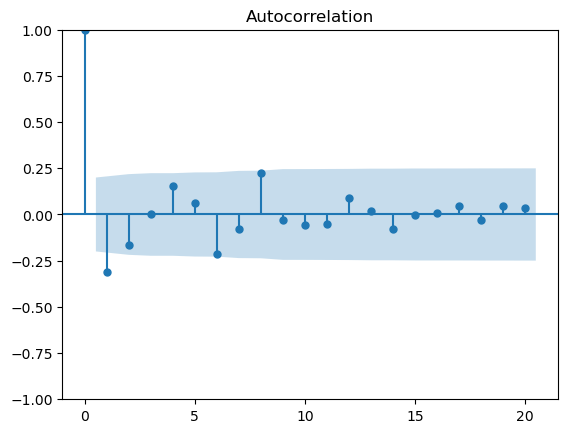

In [222]:
plot_acf(repair_weekly_diff['diff_repair_count'], lags=20)
plt.show()

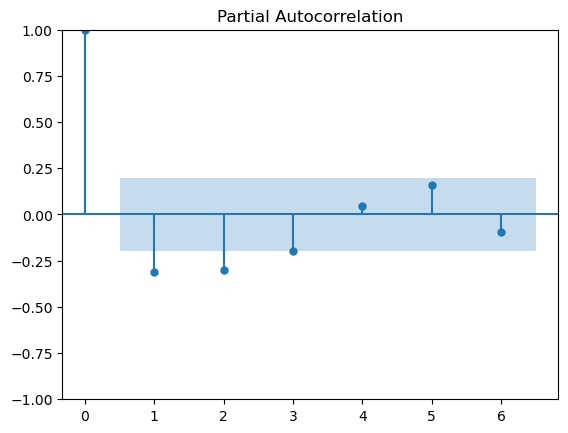

In [223]:
plot_pacf(repair_weekly_diff['diff_repair_count'], lags=6)
plt.show()

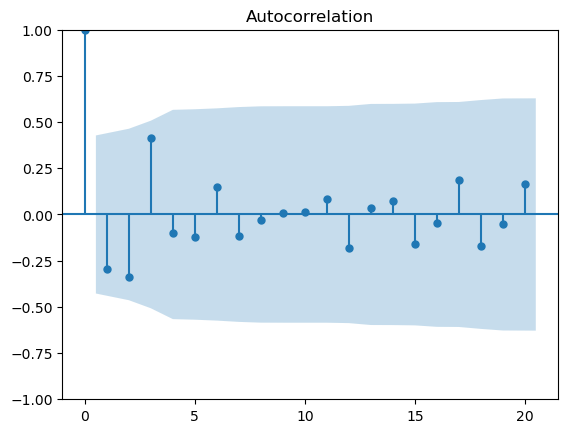

In [211]:
plot_acf(repair_monthly_2diff['2diff_repair_count'], lags=20)
plt.show()

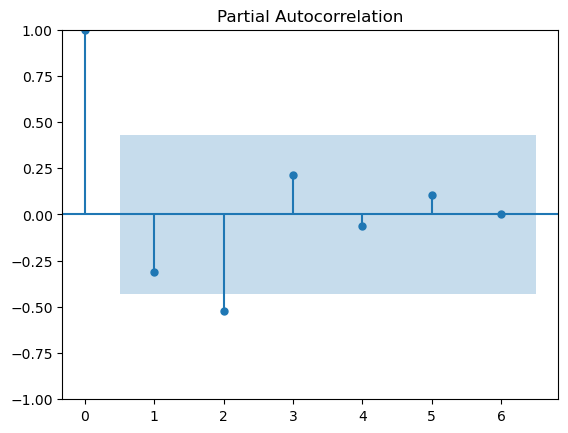

In [214]:
plot_pacf(repair_monthly_2diff['2diff_repair_count'], lags=6)
plt.show()

In [218]:
from statsmodels.stats.diagnostic import acorr_ljungbox

result = acorr_ljungbox(repair_monthly_2diff['2diff_repair_count'], lags=20)
print("p-value:", result)

p-value:       lb_stat  lb_pvalue
1    2.132548   0.144201
2    5.081104   0.078823
3    9.702769   0.021269
4    9.980937   0.040750
5   10.441682   0.063645
6   11.149710   0.083858
7   11.603044   0.114392
8   11.635609   0.168218
9   11.636752   0.234571
10  11.642276   0.309711
11  11.977581   0.365331
12  13.766657   0.315857
13  13.842217   0.385049
14  14.183279   0.436148
15  16.301749   0.362286
16  16.525117   0.416950
17  20.753664   0.237503
18  25.508978   0.111526
19  26.105049   0.127288
20  38.924078   0.006814
